<a href="https://colab.research.google.com/github/Jollyhrothgar/wordle/blob/main/Wordle_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Wordle is a word guessing game where the player needs to guess a five letter word. There are six chances to get the word right, and with each guess, you get information:

* Letters that are not in the word
* Letters that are in the word, but are not in the right position
* Letters thar are in the word and in the right position

# Strategy

Since the first word is a complete guess, the optimal guess is the one that obtains the most information. Some strageies:

## Letter frequencies

Goal: try to eliminate as many letters as possible.

1. Pick a word with distinct letters
2. Choose a word that contains the most common letters
3. First guess eliminates the most uncertainty

## Letter position frequencies

Goal: try to eliminate as many positions as possible

1. Pick a word that has distinct letters, as well as most common letter positions
2. Choose word that eliminates the most position-letter pairs
3. First guess (hopefully) eliminates both a letter AND a position.


In [4]:
#@title Imports
import urllib.request as request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
#@title Utils

def load_wordlist_from_url(url):
  """Assume URL hosts a plan newline deliminated wordlist, and load to array"""
  return [line.decode("utf-8").strip().lower() for line in request.urlopen(url)]

def make_word_df(word_list):
  """Create the word dataframe data structure"""
  words = pd.DataFrame(word_list, columns=['word'])
  words[0] = words['word'].apply(lambda x: x[0])
  words[1] = words['word'].apply(lambda x: x[1])
  words[2] = words['word'].apply(lambda x: x[2])
  words[3] = words['word'].apply(lambda x: x[3])
  words[4] = words['word'].apply(lambda x: x[4])

  return words


def compute_probability_and_frequency(word_df):
  """Given a word_list of words, compute the joint probability of all letter
  positions."""

  letter_frequency = pd.Series(
      [letter for word in word_df['word'].values for letter in word]
  ).value_counts(normalize=True)

  position_frequency = pd.concat(
    [
      word_df[0].value_counts(),
      word_df[1].value_counts(),
      word_df[2].value_counts(),
      word_df[3].value_counts(),
      word_df[4].value_counts()
    ],
    axis=1
  ).fillna(0)
  position_joint = position_frequency.div(position_frequency.sum())

  return (position_joint, letter_frequency)

def plot_words(position_joint, letter_frequency):
  fig, (ax_l, ax_r) = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
  sns.heatmap(position_joint, cmap='Blues', annot=True, fmt='.3f', ax=ax_l)
  ax_l.set_title('Wordle Joint Distribution \n $P(letter, position)$')

  # Letter frequency
  letter_frequency.plot.bar(
      title='letter frequency',
      xlabel='letter',
      ylabel='frequency',
      ax=ax_r
  )

def filter_word_df(word_df, letter, hint=None):
  """
  letter: a letter in the wordlist
  hint: A hint about the letter.
    -  '0',  '1',  '2',  '3',  '4' means letter is in word AND in position
    - '-0', '-1', '-2', '-3', '-4' means letter is in word, but NOT in position
    - None means letter is not in the word at all.
  """
  letter = letter.lower()
  if hint is None:
    return word_df[~word_df['word'].str.contains(letter)]
  elif hint in ['-0', '-1', '-2', '-3', '-4']:
    index = int(hint[-1])
    return word_df[
      (word_df[index] != letter)
      & (word_df['word'].str.contains(letter))
    ]
  elif hint in ['0', '1', '2', '3', '4']:
    index = int(hint)
    return word_df[
      (word_df[index] == letter)
    ]
  else:
    raise ValueError(f"Unhandled word hint: {hint}")

In [16]:
#@title choose a word list
url = "https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/wordle.txt" #@param ["https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/lewdle.txt", "https://raw.githubusercontent.com/Jollyhrothgar/wordle/main/wordle.txt"]
wordlist = load_wordlist_from_url(url)

print(f"Wordlist conistst of a vocabulary of {len(wordlist)} words.")

Wordlist conistst of a vocabulary of 12972 words.


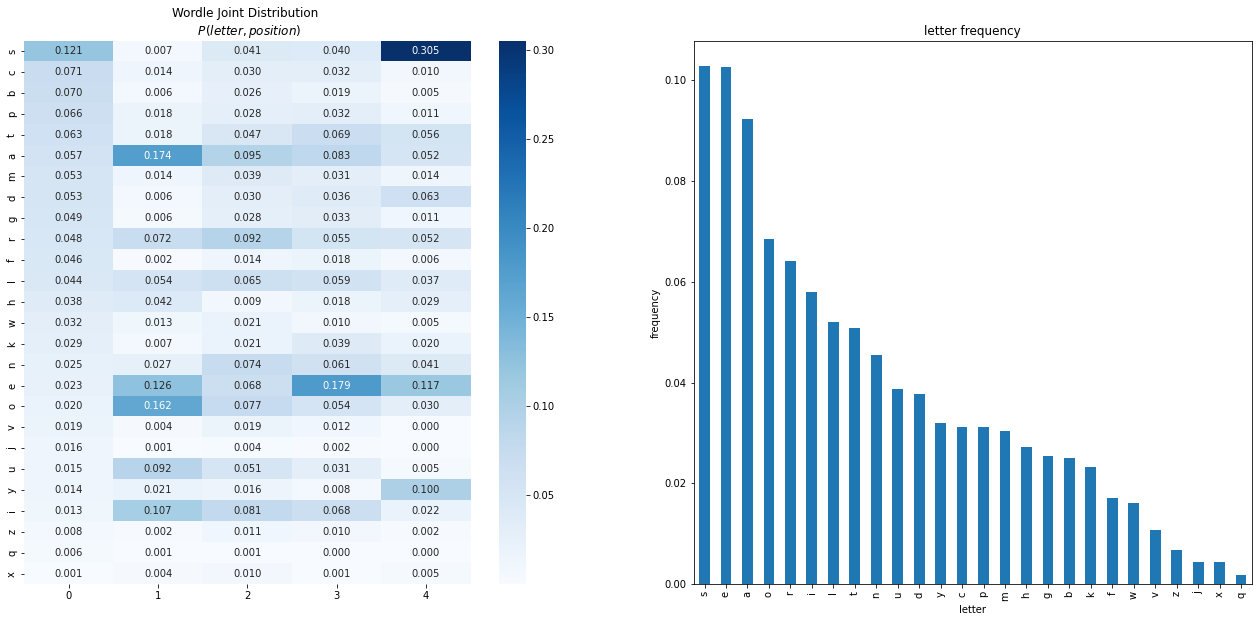

In [34]:
words = make_word_df(wordlist)
pj, lf = compute_probability_and_frequency(words)
plot_words(pj, lf)

# Example Usage:

I'm playing wordle here, and I don't know the word. The first step is to guess the first word. I choose a word that contains all the most common letters, because I will get information about which letters are in the target word or not, and rule out the most words, the most quickly.


Here's the word-list I can choose from for my first guess:

In [36]:
# First guess - pick a word that has as many unique and common letters to rule
# out words that do not have these letters.
words[
  words['word'].str.contains('s')
  & words['word'].str.contains('e')
  & words['word'].str.contains('a')
  & words['word'].str.contains('o')
]

,word,0,1,2,3,4
1252,arose,a,r,o,s,e
2425,aeons,a,e,o,n,s
2427,aeros,a,e,r,o,s
2572,aloes,a,l,o,e,s
8617,oases,o,a,s,e,s
8623,oaves,o,a,v,e,s
8937,paseo,p,a,s,e,o
9443,psoae,p,s,o,a,e
10845,soare,s,o,a,r,e
10847,soave,s,o,a,v,e


A good first guess is `TOEAS`, because it has `S`, `E`, `A`, `O` and `T` (in order of decreasing probability). For this guess, we don't care about location, we're just trying to rule out common letters. I just randomly picked it, but a better first guess would have been `AEROS`, because it has the top five most likely letters.

Now, I remove the letters with the filter library from the word list to create a new target list using the information I learneed from the guess.

I learned that none of my letters are anywhere in the target word, so I remove all of them with my filter function, saving it to a new word-list called `guess_1`.

In [39]:
guess_1 = filter_word_df(word_df=words, letter='t')
guess_1 = filter_word_df(word_df=guess_1, letter='o')
guess_1 = filter_word_df(word_df=guess_1, letter='e')
guess_1 = filter_word_df(word_df=guess_1, letter='a')
guess_1 = filter_word_df(word_df=guess_1, letter='s')

In [40]:
guess_1.shape

(555, 6)

I got lucky here - I've reduced the word space from 12972 to 555. Lets look at the probabilities again!

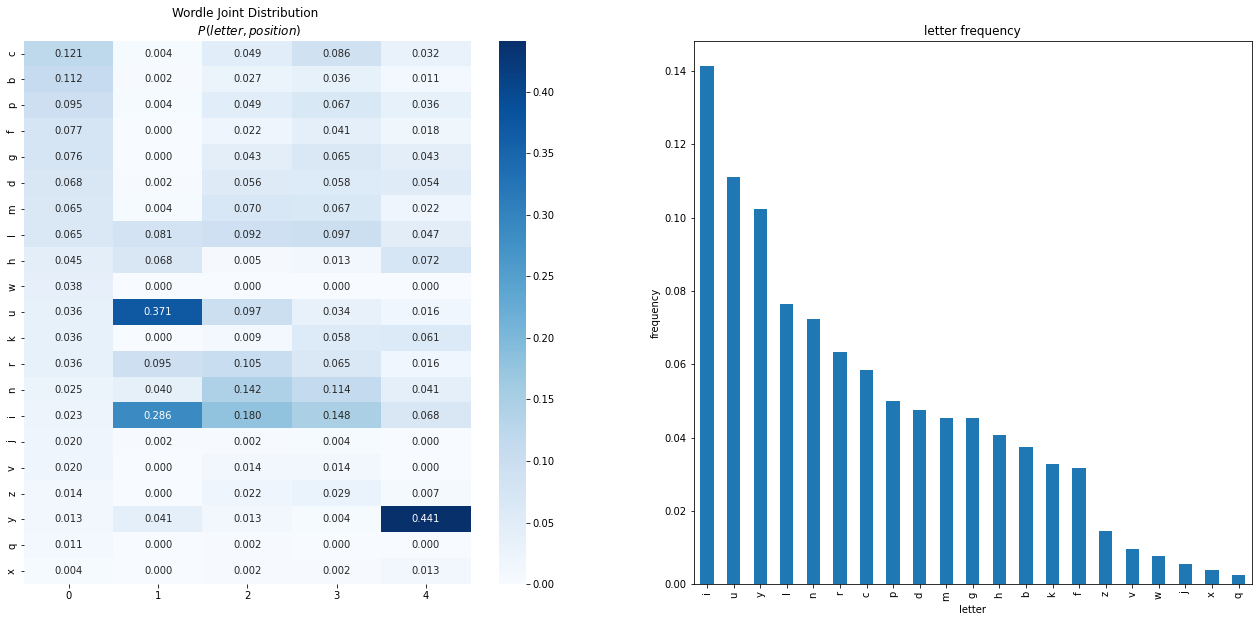

In [41]:
pj, lf = compute_probability_and_frequency(word_df=guess_1)
plot_words(pj, lf)

Interesting! It is now almost 44% likely that the letter `Y` is in the fourth position, but only ~30% likely that the first letter will be `C`, `B` or `P`.

Lets see if we can rule out even more letters using the method we used before:

In [45]:
guess_1[
  guess_1['word'].str.contains('i')
  & guess_1['word'].str.contains('u')
  & guess_1['word'].str.contains('y')
]

,word,0,1,2,3,4
195,unify,u,n,i,f,y
754,juicy,j,u,i,c,y


I added letters to filter out good words until I landed on a few remaining words. Since both words contain letters I have never guessed, they are both good candidates, but I will pick `JUICY` because it has the `Y` in the fourth position.

We learn more information here:

- `I` is in index `2`
- `C` is in index `3`
- `J`, `U` and `Y` are not in the word.

We add the filters:

In [49]:
guess_2 = filter_word_df(guess_1, letter='j')
guess_2 = filter_word_df(guess_2, letter='u')
guess_2 = filter_word_df(guess_2, letter='y')
guess_2 = filter_word_df(guess_2, letter='i', hint='2')
guess_2 = filter_word_df(guess_2, letter='c', hint='3')

print(f"Remaining words: {guess_2.shape[0]}")

guess_2

Remaining words: 10


,word,0,1,2,3,4
76,flick,f,l,i,c,k
134,click,c,l,i,c,k
216,prick,p,r,i,c,k
942,crick,c,r,i,c,k
1042,which,w,h,i,c,h
1441,brick,b,r,i,c,k
1529,chick,c,h,i,c,k
3868,chich,c,h,i,c,h
7111,klick,k,l,i,c,k
12656,wrick,w,r,i,c,k


Now, we've reduced the possible words down to 10. Lets see if there are any trends we can exploit.

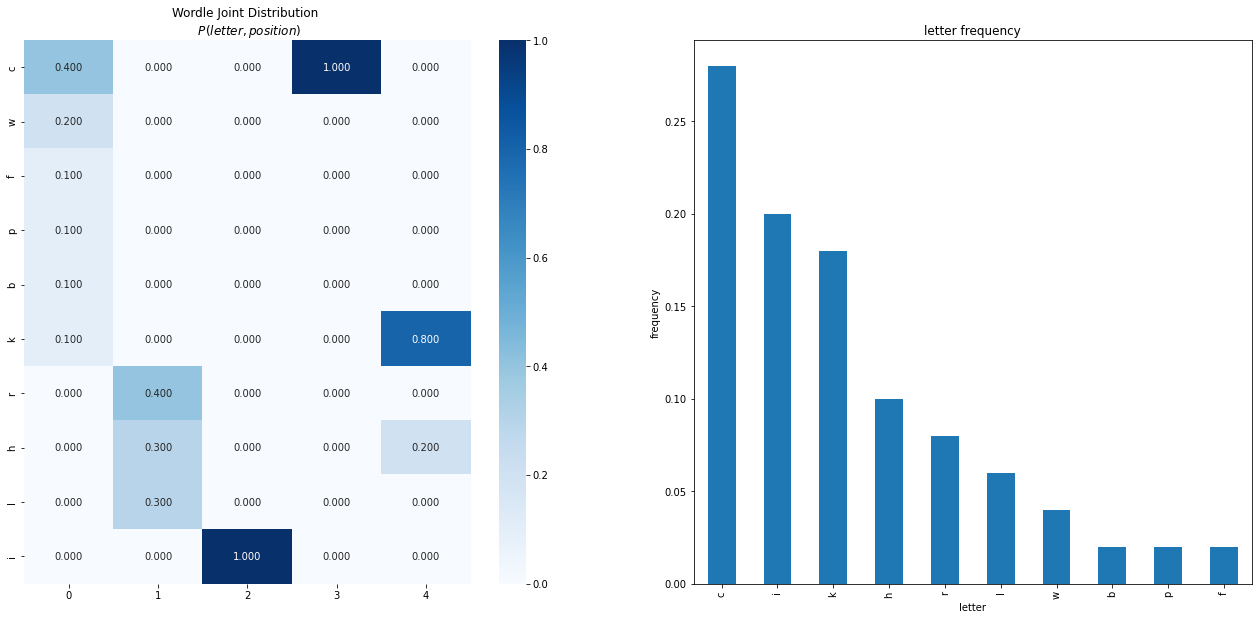

In [50]:
pj, lf = compute_probability_and_frequency(word_df=guess_2)
plot_words(pj, lf)

Now we want to start using the letter position joint distribution, since the letter frequency is over-counting both `I` and `C`. We know all ten words have `I` and `C` in them, we just want to focus on indexs 0, 1 and 4.

We're most confident that the fourth letter is a `k` (80%!). However, now we have to start guessing more randomly.

For index `0`, we are most likely to have letter `c`, but not hugely confident. For index `1`, we are mostly confident in both `r`, `h`, and `l`.

Let's see what's left when we choose `k` as the last letter.

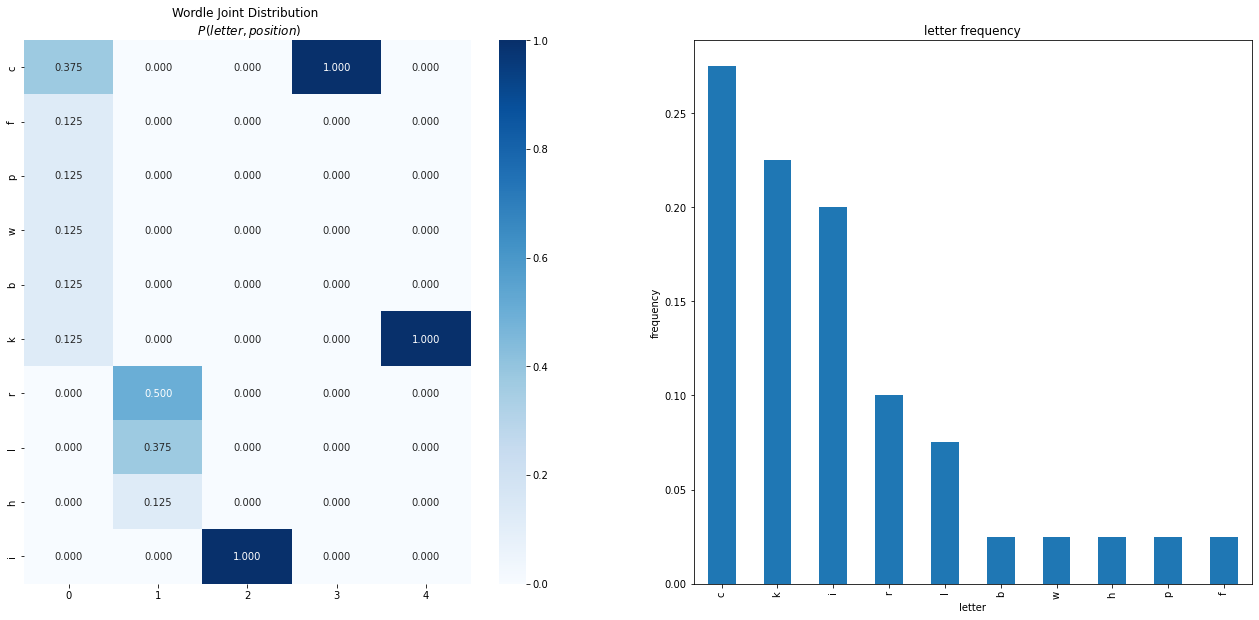

In [54]:
plot_words(*compute_probability_and_frequency(filter_word_df(word_df=guess_2, letter='k', hint='4')))

Okay, we should then probably guess `r` in the second position - what are our options if we fix `4` to be `k` and `1` to be `r`?

In [55]:
guess_2[
    (guess_2[4] == 'k')
    & (guess_2[1] == 'r')
]

,word,0,1,2,3,4
216,prick,p,r,i,c,k
942,crick,c,r,i,c,k
1441,brick,b,r,i,c,k
12656,wrick,w,r,i,c,k


Lets try `CRICK`!

...

Blast! It was not crick, but now we know the word ends exactly with `RICK`, and the first letter is not `C`.

In [58]:
guess_3 = filter_word_df(word_df=guess_2, letter='r', hint='1')
guess_3 = filter_word_df(word_df=guess_3, letter='k', hint='4')
guess_3 = filter_word_df(word_df=guess_3, letter='c', hint='-0')

print(f"remaining words {guess_3.shape[0]}")
guess_3

remaining words 3


,word,0,1,2,3,4
216,prick,p,r,i,c,k
1441,brick,b,r,i,c,k
12656,wrick,w,r,i,c,k


What can we say? We've eliminated everything but three options. Given what we know now, all three are equally likely, even though initially, the most probably first letter (out of the set of the three first letters) was `b`. But this is a bit mis-leading - at this point, no letter (`p`, `b`, or `w`) is the best option. We know for a fact that we have the 'true' remaining wordlist. There are three words all equally likely.

Just for fun, I'll guess "brick".